### 전처리

In [1]:
import pandas as pd
import numpy as np
import os

#현재경로
cur_dir = os.getcwd()

#데이터 불러오기
df = pd.read_csv(cur_dir+"/이탈_대체.csv")
#df = pd.read_csv(cur_dir+"/이탈_삭제.csv")

#df = pd.read_csv(cur_dir+"/churn_data.csv")
#df.drop('number', axis=1, inplace=True)

df['score'] = df['correct_rate_avg']*100
grade_dict = {'G011':1, 'G012':2, 'G013':3,'G014':4, 'G015':5, 'G016':6}
df['grade'] = df['grade_sect_cd'].apply(lambda x: grade_dict[x])
sex_dict = {'M':1, 'F':2, 'X':0}
df['sex'] = df['mbr_sex_cd'].apply(lambda x: sex_dict[x])

In [2]:
#신규
grade_1 = df[df['re_purch'] ==0]

In [3]:
# 필요 컬럼만 가져오기 (X : 학습 데이터, y: 레이블)
#g1X = grade_1[['grade', 'mbr_sex_cd',tmon_pchrg_lrn_dcnt', 'acmlt_pchrg_lrn_dcnt', 'acmlt_bilclct_amt','correct_rate_avg','learning_time_avg','media_action_cnt_sum','non_video_viewed_cnt_sum', 'get_mm_point_sum', 're_purch']]
g1X = grade_1[['grade', 'sex','score','learning_time_avg','tmon_pchrg_lrn_dcnt', 'acmlt_pchrg_lrn_dcnt', 'acmlt_bilclct_amt','media_action_cnt_sum','non_video_viewed_cnt_sum', 'get_mm_point_sum']]

g1y = grade_1['label']

In [4]:
# 데이터 분할하기
# Train, Test 데이터 분리
from sklearn.model_selection import train_test_split

g1X_train, g1X_test, g1y_train, g1y_test = train_test_split(g1X, g1y, test_size=0.2, random_state=42)

## 모델 선택

In [5]:
#의사결정나무(Decision Trees)
from sklearn.tree import DecisionTreeClassifier
d_model = DecisionTreeClassifier(random_state=0)
d_model.fit(g1X_train, g1y_train)

DecisionTreeClassifier(random_state=0)

In [6]:
#랜덤 포레스트 (Random Forest)
from sklearn.ensemble import RandomForestClassifier
r_model = RandomForestClassifier(random_state=0)
r_model.fit(g1X_train, g1y_train)


RandomForestClassifier(random_state=0)

In [7]:
# LGBM 모델 학습
from lightgbm import LGBMClassifier

g1_model = LGBMClassifier(random_state=0, verdose=-1)
g1_model.fit(g1X_train, g1y_train)

[LightGBM] [Warning] Unknown parameter: verdose
[LightGBM] [Warning] Unknown parameter: verdose
[LightGBM] [Info] Number of positive: 510, number of negative: 37014
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1845
[LightGBM] [Info] Number of data points in the train set: 37524, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013591 -> initscore=-4.284641
[LightGBM] [Info] Start training from score -4.284641


LGBMClassifier(random_state=0, verdose=-1)

In [8]:
# 예측
g1_y_pred = list(g1_model.predict(g1X_test))
d_y_pred = list(d_model.predict(g1X_test))
r_y_pred = list(r_model.predict(g1X_test))


# 데이터의 이탈 여부 분포 확인
print("{Grade1} 데이터 분포 확인")
print("[Train] 전체: {}, 이탈: {}, 미이탈: {}".format(len(g1X_train), (g1y_train==1).sum(),(g1y_train==0).sum()))
print("[Test] 전체: {}, 이탈: {}, 미이탈: {}".format(len(g1X_test), (g1y_test==1).sum(),(g1y_test==0).sum())) 
print("[Predict]] 전체: {}, 이탈: {}, 미이탈: {}".format(len(g1_y_pred), g1_y_pred.count(1), g1_y_pred.count(0)))

print("\nf1score")
# precision, recall, f1 score 측정
from sklearn.metrics import precision_recall_fscore_support
print("[LGBM]", precision_recall_fscore_support(g1y_test, g1_y_pred, average='binary'))
print("[의사결정]", precision_recall_fscore_support(g1y_test, d_y_pred, average='binary'))
print("[랜덤포레]", precision_recall_fscore_support(g1y_test, r_y_pred, average='binary'))

[LightGBM] [Warning] Unknown parameter: verdose
{Grade1} 데이터 분포 확인
[Train] 전체: 37524, 이탈: 510, 미이탈: 37014
[Test] 전체: 9381, 이탈: 129, 미이탈: 9252
[Predict]] 전체: 9381, 이탈: 116, 미이탈: 9265

f1score
[LGBM] (0.8448275862068966, 0.7596899224806202, 0.8, None)
[의사결정] (0.6557377049180327, 0.6201550387596899, 0.6374501992031871, None)
[랜덤포레] (0.7681159420289855, 0.4108527131782946, 0.5353535353535354, None)


In [9]:
# Accuracy 측정
from sklearn.metrics import accuracy_score

print(accuracy_score(g1y_test, g1_y_pred))

0.9947766762605266


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

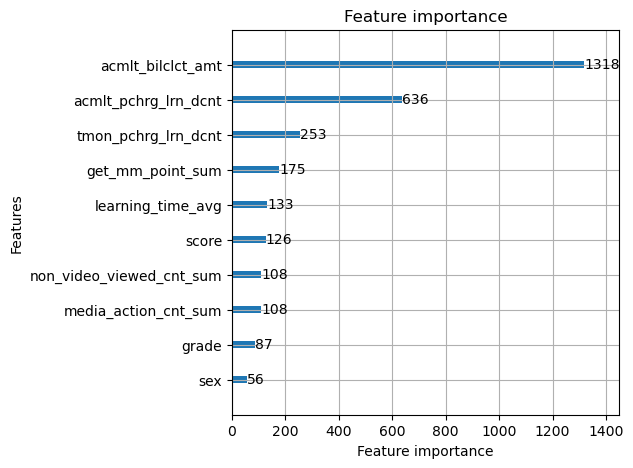

In [10]:
# 영향도 (주요 변수 시각화)
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax=plt.subplots(figsize=(5,5))
plot_importance(g1_model, ax=ax)

In [11]:
from imblearn.over_sampling import SMOTE

#오버샘플링
g1X_train_over, g1y_train_over = SMOTE(random_state=0).fit_resample(g1X_train, g1y_train)
# 모델 재훈련
ov_model = LGBMClassifier(random_state=0, verdose=-1)
ov_model.fit(g1X_train_over, g1y_train_over)

#재예측
ov_y_pred = list(ov_model.predict(g1X_test))

# 데이터 정규화: 피처 스케일링
# 데이터들이 평균은 0, 표준편차는 1이 되도록 변경하는 작업이다. (데이터가 정규분포에 따른다) 

from sklearn.preprocessing import StandardScaler, MinMaxScaler

#정규화
mm = StandardScaler()

#정규화가 필요한 데이터만 진행

mm_X_train = mm.fit_transform(g1X_train)
mm_X_test = mm.transform(g1X_test)


#최소-최대 스케일링
nn = StandardScaler()
nn_X_train = nn.fit_transform(g1X_train)
nn_X_test = nn.transform(g1X_test)

#StandardScaler
# 모델 재훈련
mm_model = LGBMClassifier(random_state=0, verdose=-1)
mm_model.fit(mm_X_train, g1y_train)

#재예측
mm_y_pred = mm_model.predict(mm_X_test)



#MinMaxScaler
# 모델 재훈련
nn_model = LGBMClassifier(random_state=0, verdose=-1)
nn_model.fit(nn_X_train, g1y_train)

#재예측
nn_y_pred = nn_model.predict(nn_X_test)


from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support
# Grid search Optimization
# LightGBM 모델 생성
model = LGBMClassifier(random_state=0, verbose=-1)
# 하이퍼파라미터 그리드 설정
param_grid = {
    'num_leaves':[10,20,30],
    'learning_rate':[0.01, 0.05, 0.1],
    'max_depth': [3,5,7],
    'min_child_sample':[10,20,30],
}

# GridSearchCV 객체 생성
grid_search = GridSearchCV(estimator=model, param_grid=param_grid)

# 그리드 서치 수행
grid_search.fit(g1X_train, g1y_train)

# 최적의 하이퍼파라미터
print("Best Parameters:", grid_search.best_params_)

# 최적의 하이퍼파라미터로 학습된 모델 가져오기
hyper_model = grid_search.best_estimator_

# 예측 수행
hyper_y_pred = hyper_model.predict(g1X_test)
precision_recall_fscore_support(g1y_test, hyper_y_pred, average='binary')

# Bayesian Optimization
import lightgbm as lgb
from bayes_opt import BayesianOptimization

# Bayesian Optimization 범위 설정
param_bayesian = {
    'num_leaves': (10, 30),
    'learning_rate':(0.01,0.1),
    'max_depth':(3,7),
    'min_child_samples': (10,30)
}

# Objective Function 메소드 설정
def lgbm_objective(num_leaves, learning_rate, max_depth, min_child_samples):
    params = {
        'num_leaves': int(num_leaves),
        'learning_rate':learning_rate,
        'max_depth': int(max_depth),
        'min_child_samples': int(min_child_samples),
        'objective': 'binary', #이진분류인 경우
        'metric':'binary_logloss'}
    
    train_data = lgb.Dataset(g1X_train, label=g1y_train)
    valid_data = lgb.Dataset(g1X_test, label=g1y_test, reference=train_data)
    model = lgb.train(params, train_data, valid_sets=[valid_data])
    
    return -model.best_score['valid_0']['binary_logloss']



# Bayesian Optimization 객체 생성
optimizer = BayesianOptimization(f=lgbm_objective, pbounds=param_bayesian, random_state=42)

# 최적화 수행
optimizer.maximize(init_points=10, n_iter=30)

# 최적의 하이퍼파라미터 출력
print(optimizer.max)

# 최적의 하이퍼파라미터로 LGBMClassifier 모델 학습
best_params = optimizer.max['params']
best_num_leaves = int(best_params['num_leaves'])
best_learning_rate = best_params['learning_rate']
best_max_depth = int(best_params['max_depth'])
best_min_child_samples = int(best_params['min_child_samples'])

best_model = LGBMClassifier(num_leaves=best_num_leaves,
              learning_rate=best_learning_rate,
              max_depth=best_max_depth,
              min_child_samples=best_min_child_samples,
              objective='binary',
              verbose=-1)

best_model.fit(g1X_train, g1y_train)

# 예측 수행
best_y_pred = best_model.predict(g1X_test)
precision_recall_fscore_support(g1y_test, best_y_pred, average='binary')



[LightGBM] [Warning] Unknown parameter: verdose
[LightGBM] [Warning] Unknown parameter: verdose
[LightGBM] [Info] Number of positive: 37014, number of negative: 37014
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2045
[LightGBM] [Info] Number of data points in the train set: 74028, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: verdose
[LightGBM] [Warning] Unknown parameter: verdose
[LightGBM] [Warning] Unknown parameter: verdose
[LightGBM] [Info] Number of positive: 510, number of negative: 37014
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1676
[LightGBM] [Info] Number of data points in the train set

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
| 3         | -0.01758  | 0.0641    | 5.832     | 10.41     | 29.4      |
[LightGBM] [Info] Number of positive: 510, number of negative: 37014
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1845
[LightGBM] [Info] Number of data points in the train set: 37524, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013591 -> initscore=-4.284641
[LightGBM] [Info] Start training from score -4.28

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
| 11        | -0.01909  | 0.04685   | 5.208     | 18.72     | 15.89     |
[LightGBM] [Info] Number of positive: 510, number of negative: 37014
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
| 19        | -0.01553  | 0.09048   | 5.462     | 24.42     | 22.23     |
[LightGBM] [Info] Number of positive: 510, number of negative: 37014
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1845
[LightGBM] [Info] Number of data points in the train set: 37524, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013591 -> initscore=-4.284641
[LightGBM] [Info] Start training from 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
| 21        | -0.01431  | 0.1       | 5.943     | 23.46     | 21.94     |
[LightGBM] [Info] Number of positive: 510, number of negative: 37014
[LightGBM] [Info] Auto-choosing 

| 24        | -0.01597  | 0.07328   | 6.912     | 23.4      | 21.41     |
[LightGBM] [Info] Number of positive: 510, number of negative: 37014
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1845
[LightGBM] [Info] Number of data points in the train set: 37524, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013591 -> initscore=-4.284641
[LightGBM] [Info] Start training from score -4.284641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
| 28        | -0.01473  | 0.1       | 5.21      | 25.56     | 20.91     |
[LightGBM] [Info] Number of positive: 510, number of negative: 37014
[LightGBM] [Info] Auto-choosing 

| 33        | -0.01425  | 0.1       | 6.8       | 26.98     | 21.29     |
[LightGBM] [Info] Number of positive: 510, number of negative: 37014
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1845
[LightGBM] [Info] Number of data points in the train set: 37524, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013591 -> initscore=-4.284641
[LightGBM] [Info] Start training from score -4.284641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
| 34        | -0.01441  | 0.08493   | 6.945     | 24.21     | 19.76   

[LightGBM] [Info] Number of positive: 510, number of negative: 37014
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1845
[LightGBM] [Info] Number of data points in the train set: 37524, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013591 -> initscore=-4.284641
[LightGBM] [Info] Start training from score -4.284641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

(0.8839285714285714, 0.7674418604651163, 0.8215767634854771, None)

In [12]:
print("\n스케일링")
print("[Basic]:", precision_recall_fscore_support(g1y_test, g1_y_pred, average='binary'))
print("[OverSampling]:", precision_recall_fscore_support(g1y_test, ov_y_pred, average='binary'))
print("[StandardScaler]:", precision_recall_fscore_support(g1y_test, mm_y_pred, average='binary'))
print("[MinMaxScaler]:", precision_recall_fscore_support(g1y_test, nn_y_pred, average='binary'))

print("\n[Basic]최적화")
print("[Grid]:", precision_recall_fscore_support(g1y_test, hyper_y_pred, average='binary'))
print("[Optimizer]:",precision_recall_fscore_support(g1y_test, best_y_pred, average='binary'))


print(accuracy_score(g1y_test, best_y_pred))


스케일링
[Basic]: (0.8448275862068966, 0.7596899224806202, 0.8, None)
[OverSampling]: (0.6648351648351648, 0.937984496124031, 0.7781350482315113, None)
[StandardScaler]: (0.8521739130434782, 0.7596899224806202, 0.8032786885245902, None)
[MinMaxScaler]: (0.8521739130434782, 0.7596899224806202, 0.8032786885245902, None)

[Basic]최적화
[Grid]: (0.8623853211009175, 0.7286821705426356, 0.7899159663865546, None)
[Optimizer]: (0.8839285714285714, 0.7674418604651163, 0.8215767634854771, None)
0.995416266922503


In [13]:
#오버샘플링한것 최적화


# 그리드 서치 수행
grid_search.fit(g1X_train_over, g1y_train_over)

# 예측 수행
hyper_y_pred = hyper_model.predict(g1X_test)

best_model.fit(g1X_train_over, g1y_train_over)

# 예측 수행
best_y_pred = best_model.predict(g1X_test)

# 예측 수행
best_y_pred = best_model.predict(g1X_test)
print("[오버샘플링]")
print("[Grid]:",precision_recall_fscore_support(g1y_test, hyper_y_pred, average='binary'))
print("[Optimizer]:",precision_recall_fscore_support(g1y_test, best_y_pred, average='binary'))

[오버샘플링]
[Grid]: (0.8623853211009175, 0.7286821705426356, 0.7899159663865546, None)
[Optimizer]: (0.5168067226890757, 0.9534883720930233, 0.670299727520436, None)


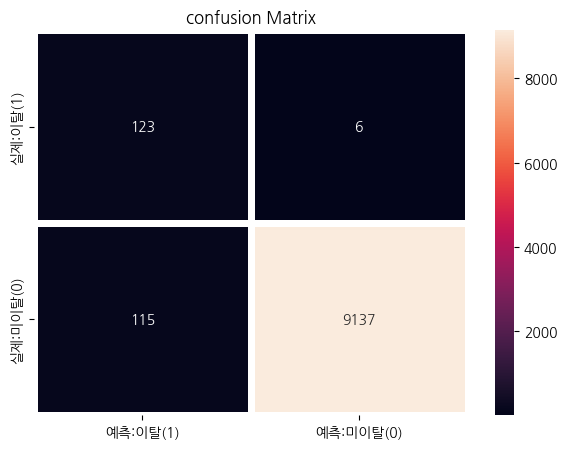

In [14]:
from sklearn.metrics import confusion_matrix
#오버샘플링 optimizer 최적화cmtx

# cmtx 구성
cmtx = pd.DataFrame(confusion_matrix(g1y_test, best_y_pred, labels = [1,0]),
        index=['실제:이탈(1)', '실제:미이탈(0)'],
        columns = ['예측:이탈(1)', '예측:미이탈(0)'])

# cmtx 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib # 한글 폰트 안 깨지고 사용 가능
# pip install koreanize-matplotlib

plt.figure(figsize=(7,5))
plt.title("confusion Matrix")
sns.heatmap(cmtx, annot=True, fmt=".0f", linewidth=5)
plt.show()